# Оценка проведения A/B-теста

Внутри компании-заказчика был проведен A/B-тест, нацеленный на выявление изменений, свзанных с внедреним улучшенной рекомендательной системы. 

**Цель данного исследования:** оценить корректность проведения теста.

Содержание:

[1 Выгрузка данных](#выгрузка)\
[2 Предобработка данных](#предобработка)\
    - [2.1 Обработка типов](#типы)\
    - [2.2 Обработка пропусков](#пропуски)\
    - [2.3 Обработка дубликатов](#дубликаты)\
    - [2.3 Вывод](#вывод_2)\
[3 Оценка корректности проведения теста](#корректность)\
    - [3.1 Соответствие данных требованиям технического задания](#задание)\
    - [3.2  Время проведения теста](#время)\
    - [3.3 Аудитория теста](#аудитория)\
    - [3.4 Вывод](#вывод_3)\
[4 Исследовательский анализ данных](#иа)\
    - [4.1 Распределение количества событий на пользователя в выборках](#по_пользователям)\
    - [4.2 Распределение количества событий по дням](#по_дням)\
    - [4.3 Изменение конверсии в воронке в выборках на разных этапах](#конверсия)\
    - [4.4 Особенности данных перед A/B-тестированием](#особенности)\
    - [4.5 Вывод](#вывод_4)\
[5 Оценка результатов A/B-тестирования](#тест)\
    - [5.1 Результаты A/B-тестирования](#результаты_теста)\
    - [5.2 Проверка статистической разницы долей z-критерием](#з-критерий)\
    - [5.3 Вывод](#вывод_5)\
[6 Вывод](#вывод_6)














## Описание данных 
В нашем распоряжении датасеты: 
- Календарь маркетинговых событий на 2020 год;
- Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года;
- Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
- Таблица участников тестов.

<a id='выгрузка'></a>
## 1 Выгрузка данных

In [182]:
# импорт библиотек
from scipy import stats as st
import numpy as np
import math as mth
import pandas as pd
import datetime as dt
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

warnings.filterwarnings("ignore")

In [183]:
events = pd.read_csv('final_ab_events.csv')
marketing = pd.read_csv('ab_project_marketing_events.csv')
new_users = pd.read_csv('final_ab_new_users.csv')
participants = pd.read_csv('final_ab_participants.csv')

<a id='типы'></a>
### 2.1 Преобразование типов
Проверим датасеты на корректность типов столбцов.

In [184]:
for df in [events, marketing, new_users, participants]:
    df.info()
    print(' ')
    print(' ')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   use

Столбцы, содержащие в себе информацию о времени, следует привести к типу дата-время.

In [185]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])
new_users['first_date'] = new_users['first_date'].astype('datetime64[D]')

<a id='пропуски'></a>
### 2.2 Пропущенные значения 
Проверим, есть ли в данных пропущенные значения и попробуем описать природу их возникновения.

In [186]:
for df in [events, marketing, new_users, participants]:
    display(df.isna().sum())

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

user_id       0
first_date    0
region        0
device        0
dtype: int64

user_id    0
group      0
ab_test    0
dtype: int64

Пропущенные значения обнаружены только в датасете events в столбеце `details`. 

In [187]:
print("Всего строк в датасете:", events['user_id'].count())
print("Число пропусков в столбце `details`:", events['details'].isna().sum())
print(f"Пропущено {(events['details'].isna().sum() * 100 / events['user_id'].count()).round(2)}% значений")

Всего строк в датасете: 440317
Число пропусков в столбце `details`: 377577
Пропущено 85.75% значений


Пропущено 85.75% значений. Природа этих пропусков может быть связана с тем, что столбец `details` хранит в себе дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах. Для других событий, например для регистрации, такой информации не требуется. 

<a id='дубликаты'></a>
### 2.3 Дубликаты
Проверим есть ли в данных дубликаты.

In [188]:
def dup_sum(df):
    if df.duplicated().sum()>0:
        print(f'В датасете обнаружено полных дубликатов: {df.duplicated().sum()}')
    else:
        print('Полных дубликатов в данных не обнаружено')

In [189]:
for df in [events, marketing, new_users, participants]:
    dup_sum(df)

Полных дубликатов в данных не обнаружено
Полных дубликатов в данных не обнаружено
Полных дубликатов в данных не обнаружено
Полных дубликатов в данных не обнаружено


Проверка показала, что ни один из четырех датасетов не имеет полных дубликатов.

<a id='вывод_2'></a>
### 2.4 Вывод

На данном этапе была проделана предобработка данных:
- Преобразованы типы данных, содержащих в себе дату-время;
- Проверены и описаны пропуски. Пропущенные значения обнаружены только в датасете events в столбеце `details`. Их появление связано с назначением этого столбца (не каждому событию сопутствуют какие-то детали типа стоимости покупок).
- Проверены дубликаты. Дубликатов в данных не оказалось.

<a id='корректность'></a>
## 3 Оценка корректности проведения теста

Оценим корректность проведения теста по следующим параметрам:
- 1 Соответствие данных требованиям технического задания. Проверим корректность всех пунктов технического задания; 
- 2 Время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями.
- 3 Аудиторию теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.

**Техническая часть**

In [190]:
# функция для оформления графиков
def plt_design(title='title',
               title_size=18, 
               xlabel='xlabel', 
               ylabel='ylabel',
               fontsize=14, # размер шрифта подписей к осям
               ticks_size=12, # размер шрифта делений на осях
               xrot=0, # наклон подписей делений
               yrot=0,
               ):
    
    plt.title(title, fontsize = title_size)
    plt.xlabel(xlabel, fontsize=fontsize) 
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(fontsize = ticks_size, rotation=xrot)
    plt.yticks(fontsize = ticks_size, rotation=yrot)
    
    
    return
plt.show();

<a id='задание'></a>
### 3.1 Соответствие данных требованиям технического задания

Выполним следующие шаги:
- Описание теста
- Проверка дат:
    - дата запуска: 2020-12-07;
     - дата остановки набора новых пользователей: 2020-12-21;
     - дата остановки: 2021-01-04; 

- Проверка состава аудитории:
     - 15% новых пользователей из региона EU;
     
 - Фильтрация событий:
     - Лайфтайм событий пользователя не должен превышать 14 дней;
     
 - Проверка количества участников теста: 6000.


#### Описание теста
    
- Название теста: `recommender_system_test`;
- Группы: А — контрольная, B — новая платёжная воронка;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

#### Проверка дат
Необходимо убедиться в том, что данные соответсвуют следующим датам:
- Дата запуска: 2020-12-07
- Дата остановки набора новых пользователей: 2020-12-21
- Дата остановки: 2021-01-04

На данном шаге отфильтруем новых пользователей, зарегестрировавшихся до 21-12-2020. Для этого выясним минмальные и максимальные даты регистрации пользователей.

In [191]:
display(new_users['first_date'].dt.date.min())
display(new_users['first_date'].dt.date.max())

datetime.date(2020, 12, 7)

datetime.date(2020, 12, 23)

Посмотрим дату остановки набора нашего теста. Для этого объединим таблицы participants с нужным тестом и new_users и посмотрим на окончание теста: 

In [192]:
display(new_users.merge(participants.query('ab_test == "recommender_system_test"'), on='user_id')['first_date'].dt.date.max())

datetime.date(2020, 12, 21)


Получившаяся дата соответствует заданию: все участники теста зарегестрированы до 21-12-2020. Сохраним подходящие по датам регистрации пользователей в список 'filtered_user_id'.

In [193]:
# создадим список user_id, которые подходят по датам регистрации, чтобы потом сравнивать с другими фреймами
filtered_user_id = new_users.merge(participants.query('ab_test == "recommender_system_test"'), on='user_id')['user_id']

#### Аудитория: 15% новых пользователей из региона EU
Чтобы проверить данный пункт, возьмем всех пользователей из Европы, зарегестрировавшихся в даты проведения теста, и посчитаем, какая доля попала в наш тест.

In [194]:
# берем всех пользователей из EU, которые регестрировались до 21 числа включительно:
all_eu_users = new_users.query("region == 'EU' and first_date<='2020-12-21'")['user_id'].nunique() 

# список user_id, попавших в наш тест:
participants_list = participants.query("ab_test == 'recommender_system_test'")['user_id']

# число пользователей из европы, попавшие в тест и зарегестрированные до 21 числа:
test_eu_users = new_users.query("region == 'EU' and user_id in @participants_list and first_date <= '2020-12-21'")['user_id'].nunique() 

share_eu = round((test_eu_users / all_eu_users * 100) ,2 )
print(f"Процент новых пользователей из Европы: {share_eu}%")

Процент новых пользователей из Европы: 15.0%


Получившееся значение соотносится с предъявляемыми требованиями.

#### Фильтрация событий

Мы анализируем изменение метрик за 14 дней с момента регистрации. Все пользователи должны быть зарегестрированным, не позднее 21-12-2020 (Эти пользователи в списке filtered_user_id). Все события пользователя, должны быть совершены в 14-дневный лайфтайм. То есть события, которые старше 14 дней, надо удалить. Для этого отфильтруем события, не успевшие войти в двухнедельный лайфтайм.

In [195]:
# у каждого пользователя есть дата первого события:
start_event = events.groupby('user_id')['event_dt'].min().reset_index()
start_event.columns=['user_id', 'first_event']

# добавляем эту дату в таблицу events:
events = events.merge(start_event, on='user_id')

# отсекаем невошедшие в 14-дневный лайфтайм СОЫТИЯ:
events = events.loc[(events['event_dt'] - events['first_event']) <= timedelta(days=14)]
events.head()

,user_id,event_dt,event_name,details,first_event
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07 20:22:03
1,E1BDDCE0DAFA2679,2020-12-09 06:21:35,purchase,9.99,2020-12-07 20:22:03
3,E1BDDCE0DAFA2679,2020-12-07 20:22:03,login,NaN,2020-12-07 20:22:03
4,E1BDDCE0DAFA2679,2020-12-09 06:21:35,login,NaN,2020-12-07 20:22:03
6,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07 09:22:53


#### Проверка количества участников теста
    
Ожидаемое количество участников теста: не менее 6000. Нам нужны только те пользователи, которых мы выделили выше. На данном этапе, проверим сколько пользователей из new_users попало в наш тест. 
</div>

In [196]:
unfiltered_participants = participants
unfiltered_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [197]:
# считаем, сколько из них участвуют в тесте:
participants = participants.query("user_id in @filtered_user_id" and "ab_test == 'recommender_system_test' ")
participants['user_id'].nunique()

6701

**Промежтучный вывод:**
    
- На этапе проверки дат пользователей, участвоваших в тесте и зарегестрировавшихся позже 21-12-2020 – не обнаружено . Сохранили список отфильтрованных пользователей в переменную filtered_user_id;
- Проверка состава аудитории подтвердила, что 15% новых пользователей из региона EU;
- На этапе проверки конверсий мы отсекли те события, которые пользователи не успели сделать в 14-дневный лайфтайм;
- На этапе проверки количества участников теста мы выделили только тех пользователей, которые: а)зарегестрировались не позднее 21-12-2020; б) учатсвовали в тесте "recommender_system_test". Также проверка подтвердила, что участников теста 'recommender_system_test' больше 6000, а именно 6701. 



<a id='время'></a>
### 3.2 Время проведения теста
Убедимся, что время проведения теста не совпадает с маркетинговыми и другими активностями.
Есть четыре варианта пересечения маркетинговой кампании с датами проведения теста:
1) Начались до периода, закончились после
2) Начались во время периода, закончились во время периода
3) Начались во время периода, закончились после
4) Начались до периода, закончились во время

Даты проведения теста 7 декабря - 4 января. Сравним с ними даты проведения маркетинговых кампаний: 

In [198]:
A = datetime.date(2020, 12, 7) # начало теста
B =datetime.date(2021, 1, 4) # конец теста

# Начались до периода, закончились после
print('Начались до периода, закончились после:', 
        marketing.query('start_dt < @A and finish_dt > @B')['name'].nunique())

# Начались во время периода, закончились во время периода
print('Начались во время периода, закончились во время периода:',
      marketing.query('start_dt >= @A and start_dt < finish_dt and finish_dt <= @B')
      ['name'].nunique())

# Начались во время периода, закончились после
print('Начались во время периода, закончились после:',
    marketing.query('start_dt >= @A  and start_dt <= @B and finish_dt > @B')['name'].nunique())

# Начались до периода, закончились во время
print('Начались до периода, закончились во время:',
    marketing.query('start_dt < @A and finish_dt >= @B and finish_dt <= @B')['name'].nunique())



Начались до периода, закончились после: 0
Начались во время периода, закончились во время периода: 1
Начались во время периода, закончились после: 1
Начались до периода, закончились во время: 0


In [199]:
display( print('Начались во время периода, закончились во время периода'), 
        marketing.query('start_dt >= @A and start_dt < finish_dt and finish_dt <= @B')  )
print(' ')
print(' ')
display( print('Начались во время периода, закончились после'),
        marketing.query('start_dt >= @A  and start_dt <= @B and finish_dt > @B')  )

Начались во время периода, закончились во время периода


None

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


 
 
Начались во время периода, закончились после


None

,name,regions,start_dt,finish_dt
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Обнаружены маркетинговые кампании, пересекающиеся с датами проведения теста:
- Christmas&New Year Promo началась 25 декабря и закончилась 3 января;
- CIS New Year Gift Lottery началась 30 декабря и закончилась 7 янвваря.

Посмотрим динамику количества событий по группам А и Б и если в этот момент нет какого-то диспропорционального поведения графиков - следует признать маркетинговые события не влияющими на наш тест.

In [200]:
events.head()

,user_id,event_dt,event_name,details,first_event
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07 20:22:03
1,E1BDDCE0DAFA2679,2020-12-09 06:21:35,purchase,9.99,2020-12-07 20:22:03
3,E1BDDCE0DAFA2679,2020-12-07 20:22:03,login,NaN,2020-12-07 20:22:03
4,E1BDDCE0DAFA2679,2020-12-09 06:21:35,login,NaN,2020-12-07 20:22:03
6,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07 09:22:53


In [201]:
# создадим дополнительный столбец с датой:
events['dt'] = pd.to_datetime(events['event_dt']).dt.date

# сгруппируем данные по дате и посчитаем количество событий в тот или иной день:
event_frequency = events.groupby('dt', as_index=False)['event_name'].count()
event_frequency.columns=['dt', 'event_cnt']
event_frequency.head()


,dt,event_cnt
0,2020-12-07,11385
1,2020-12-08,12547
2,2020-12-09,12122
3,2020-12-10,14077
4,2020-12-11,13864


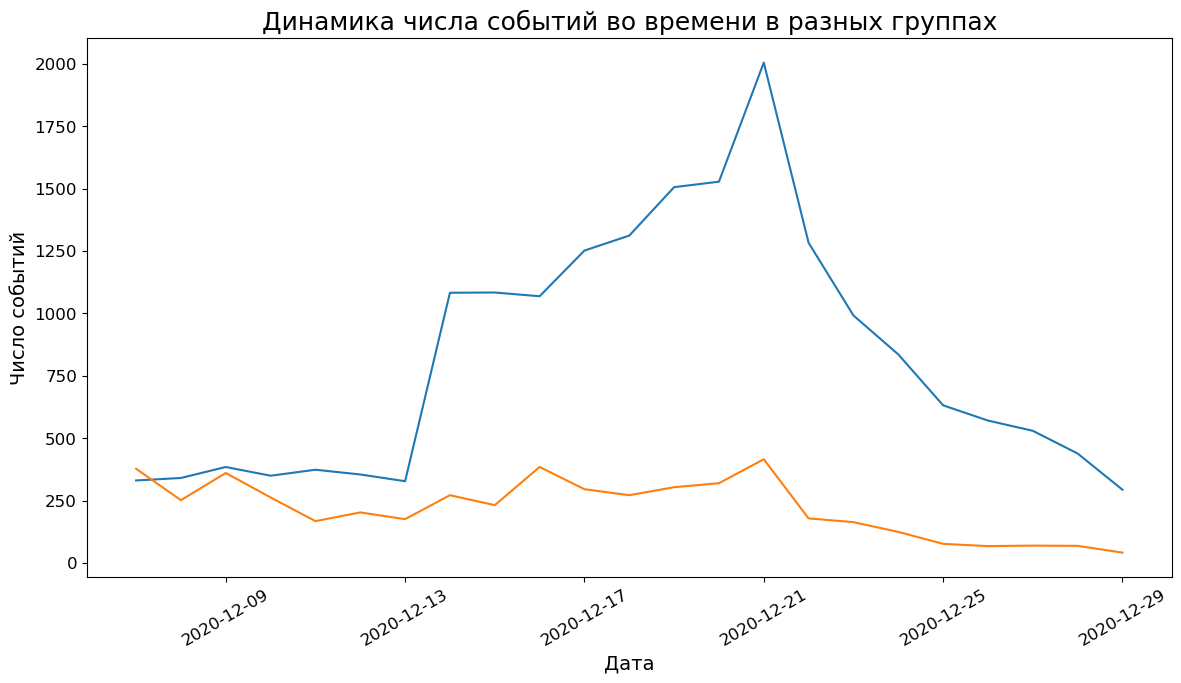

In [202]:
# разделим пользователей по группам:
users_a = participants[participants['group']=='A']['user_id'].unique()
users_b = participants[participants['group']=='B']['user_id'].unique()

# Посмотрим число событий 
events_groups = events.merge(participants[['user_id', 'group']], on='user_id')
events_groups = events_groups[['user_id', 'event_dt', 'event_name', 'group']]
events_groups

# создадим дополнительный столбец с датой:
events_groups['dt'] = pd.to_datetime(events_groups['event_dt']).dt.date

# сгруппируем данные по дате и посчитаем количество событий в тот или иной день:
event_frequency = events_groups.groupby(['dt','group'], as_index=False)['event_name'].count()
event_frequency.columns=['dt', 'group', 'event_cnt']
event_frequency.head()

x=event_frequency.query('group=="A"')['dt']
ya=event_frequency.query('group=="A"')['event_cnt']
yb=event_frequency.query('group=="B"')['event_cnt']

plt.figure(figsize=(14,7))

plt.plot(x, ya)
plt.plot(x, yb)

plt_design(title='Динамика числа событий во времени в разных группах',
               xlabel='Дата', 
               ylabel='Число событий',
               xrot=30, # наклон подписей делений
               )

Число событий у группы B не сильно изменяется: значения в диапазоне 100–350. Число событий группы А резко возрастает 13-12-2020 и продолжает свой рост, но уже спокойнее до 21-12-2020. После этой даты график резко уменьшается до исходных значений. Ранее мы получили, что была рождественская маркетинговая кампания во время периода, она началась 25 декабря и закончились 3 января. Даты пиков не совпадают с датами праздников. Таким образом, изменения поведения пользоватлеей с маркетинговой кампанией не связаны. CIS New Year Gift Lottery началась 30 декабря и закончилась 7 янвваря.Все события происходят до 29 декабря, то есть влияние на группы не оказывает.

**Промежуточный вывод**
- Найдены пересечения маркетинговых дат с датами проведения теста. Во время периода началась и закончилась кампания "Christmas&New Year Promo"; начались во время периода и закончились после: "CIS New Year Gift Lottery".
- Число событий группы сильно изменяется, но не из-за проведения маркетинговых кампаний.

<a id='аудитория'></a>
### 3.3 Аудитория теста 
 Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.

Проверим нет ли пересечений пользоватлеей между группами:

In [203]:
# пересечения в группах:
cross_id = (participants.groupby('user_id')['group']
          .nunique()
          .reset_index()
          .query('group > 1')
          .user_id
          .unique()
         )

if participants.query('user_id in @cross_id')['user_id'].count() >=1:
    print(participants.query('user_id in @cross_id')) 
else: 
    print('Пересечений пользователей в группах А и B нет');

Пересечений пользователей в группах А и B нет


Вычислим число участников в каждой из групп:

In [204]:
display(participants.groupby('group')['user_id'].nunique());

group
A    3824
B    2877
Name: user_id, dtype: int64

Группы отличаются всего на 947 участников, что составляет 14% от всего числа участников. 

Теперь выясним, не пересекаются ли участники разных тестов:

In [205]:
unfiltered_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [206]:
corr_a = unfiltered_participants.query('ab_test == "recommender_system_test"')
corr_b = unfiltered_participants.query('ab_test == "interface_eu_test"')
#Подсчёт кол-ва пересеченных пользователей
print(len(corr_a['user_id'].unique()) + len(corr_b['user_id'].unique()) - len(unfiltered_participants['user_id'].unique()))

1602


**Промежуточный вывод**
- Пересечений между учатсниками разных групп не обнаружено;
- Вес групп: А – 3824 участника, B – 2877. Разница между группами незначительна, а также группы достаточно велики;
- Обнаружены пересечения между участниками разных тестов.

<a id='вывод_3'></a>
### 3.4 Вывод

На данном этапе была проведена оценка корректности проведения теста по следующим параметрам:
- 1 Соответствие данных требованиям технического задания; 
- 2 Время проведения теста;
- 3 Аудитория теста;

В каждом пункте сформулированы следующие выводы:

**1 Соответствие данных требованиям технического задания:**
- На этапе проверки дат мы убедились, что пользователей-участников нашего теста, зарегестрировавшихся позже 21-12-2020 - нет;
- Проверка состава аудитории подтвердила, что 15% новых пользователей из региона EU;
- На этапе проверки конверсий мы отсекли те события, которые пользователи не успели сделать в 14-дневный лайфтайм;
- На этапе проверки количества участников теста мы выделили только тех пользователей, которые: а)зарегестрировались не позднее 21-12-2020; б) учатсвовали в тесте "recommender_system_test". Также проверка подтвердила, что участников теста 'recommender_system_test' больше 6000, а именно 6701. 

**2 Время проведения теста:**
- Найдены пересечения маркетинговых дат с датами проведения теста. Во время периода началась и закончилась кампания "Christmas&New Year Promo"; начались во время периода и закончились после: "CIS New Year Gift Lottery".
- Число событий группы сильно изменяется, но не из-за проведения маркетинговых кампаний.

**3 Аудитория теста:**
- Пересечений между учатсниками разных групп не обнаружено;
- Вес групп: А – 3824 участника, B – 2877. Разница между группами незначительна;
- Обнаружены пересечения участников разных тестов. 

<a id='иа'></a>
## 4 Исследовательский анализ данных

<a id='по_пользователям'></a>
### 4.1 Распределение количества событий на пользователя в выборках 

Проверим одинаково ли количество событий на пользователя в разрезе групп A и B. Для этого посчитаем для каждого пользователя количество событий и проанализируем результаты в разбивке по группам.

In [207]:
# распределение числа событий по пользователям разных групп:
dist = events_groups.groupby(['user_id', 'group'], as_index=False)['event_dt'].count()
dist = dist.rename(columns={'event_dt':'event_cnt'})

display(dist.head())

,user_id,group,event_cnt
0,001064FEAAB631A1,B,6
1,0010A1C096941592,A,12
2,00341D8401F0F665,A,2
3,003DF44D7589BBD4,A,15
4,00505E15A9D81546,A,5


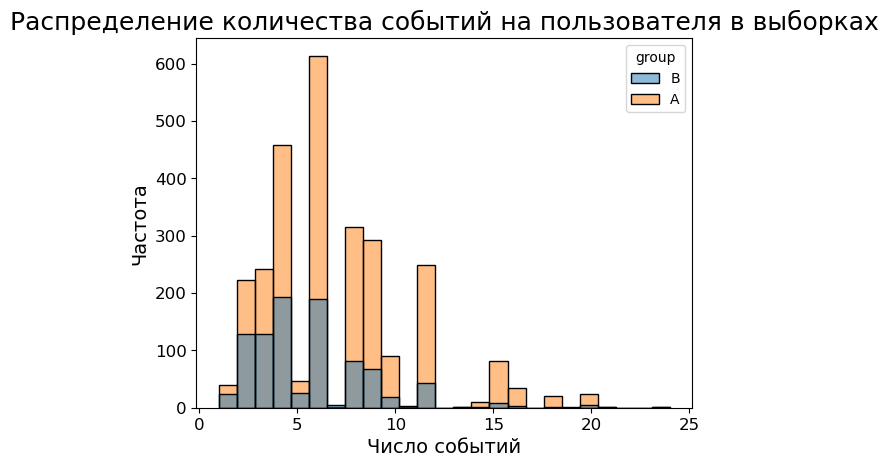

In [208]:
sns.histplot(dist, x="event_cnt", hue="group", bins=25)

plt_design(title='Распределение количества событий на пользователя в выборках',
               xlabel='Число событий', 
               ylabel='Частота',
               )

- Числа событий пользователя что в группе А, что в группе В, находится в диапазоне от 1 до 25. И основная масса значений в обеих группах сконцентрирована на отметке 6;
- Пользователи группы А чаще проделывают по 4 или по 6 событий. Также выделяют значенияя: 8-9 и 12 событий. 
- Пользователи группы B в целом совершают действий меньше, однако пиковые значения соответсвуют тем же показателям

Таким образом, число событий на пользователя в группах распределено одинаково.

<a id='по_дням'></a>
### 4.2 Распределение количества событий по дням 

Выясним, как число событий в выборках распределено по дням.

In [209]:
events_groups.head()

,user_id,event_dt,event_name,group,dt
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,A,2020-12-07
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,A,2020-12-09
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,A,2020-12-07
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,A,2020-12-08
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,A,2020-12-09


In [210]:
# распределение числа событий по дням в разных группах:
dist_by_dt = events_groups.groupby(['dt', 'group'], as_index=False)['event_dt'].count()
dist_by_dt = dist_by_dt.rename(columns={'event_dt':'event_cnt'})

display(dist_by_dt.head())

,dt,group,event_cnt
0,2020-12-07,A,331
1,2020-12-07,B,378
2,2020-12-08,A,341
3,2020-12-08,B,252
4,2020-12-09,A,385


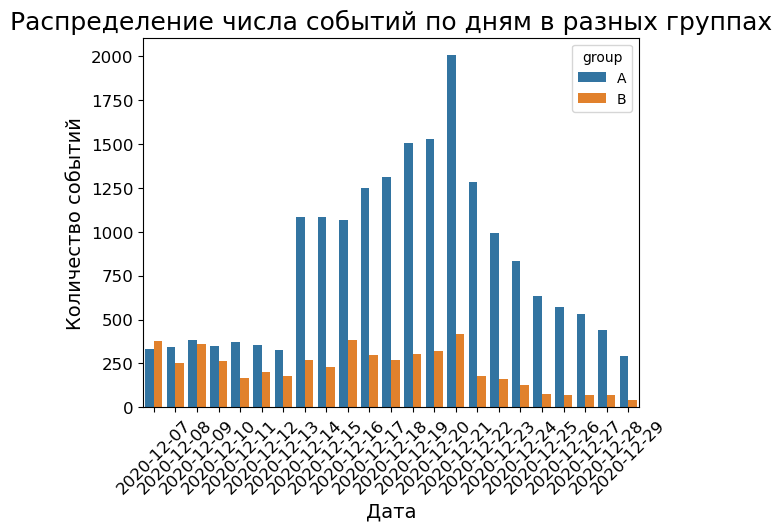

In [211]:
sns.barplot(data=dist_by_dt, x="dt", y="event_cnt", hue="group")

plt_design(title='Распределение числа событий по дням в разных группах',
               xlabel='Дата', 
               ylabel='Количество событий',
               xrot=45
               )

- Число событий пользователей группы А по показателям выше показателей группы B, кроме первого дня (7 дек 2020);
- Особенно сильно выделяются даты 13-12-2020 – 21-12-2020. Здесь активность группы А сильно возрастает, достигает максимума 21 янаваря и резко идет на понижение;
- Число событий в группе В распределено по дням более равномерно относительно группы А. Значения колеблятся в диапазоне 200–300 событий, и 21-12-2020 так же, как и в группе А, идут на понижение.

<a id='конверсия'></a>
### 4.3 Изменение конверсии в воронке в выборках на разных этапах

#### Получение воронки событий
Посмотрим, как часто встречается то или иное событие. А также посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. 

In [212]:
events_groups.head()

,user_id,event_dt,event_name,group,dt
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,A,2020-12-07
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,A,2020-12-09
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,A,2020-12-07
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,A,2020-12-08
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,A,2020-12-09


In [213]:
# распределение числа событий и пользователей по типам события в разных группах:
funnel = (events_groups.groupby(['event_name', 'group'], as_index=False)
       .agg({'event_dt':'count', 'user_id':'nunique'})
          .rename(columns={"event_dt": "event_cnt", 'user_id':'user_cnt'})
          .sort_values('user_cnt', ascending=False)
      )
funnel 

,event_name,group,event_cnt,user_cnt
0,login,A,8371,2747
4,product_page,A,5396,1780
1,login,B,2475,927
6,purchase,A,2605,872
2,product_cart,A,2508,824
5,product_page,B,1323,523
7,purchase,B,638,256
3,product_cart,B,656,255


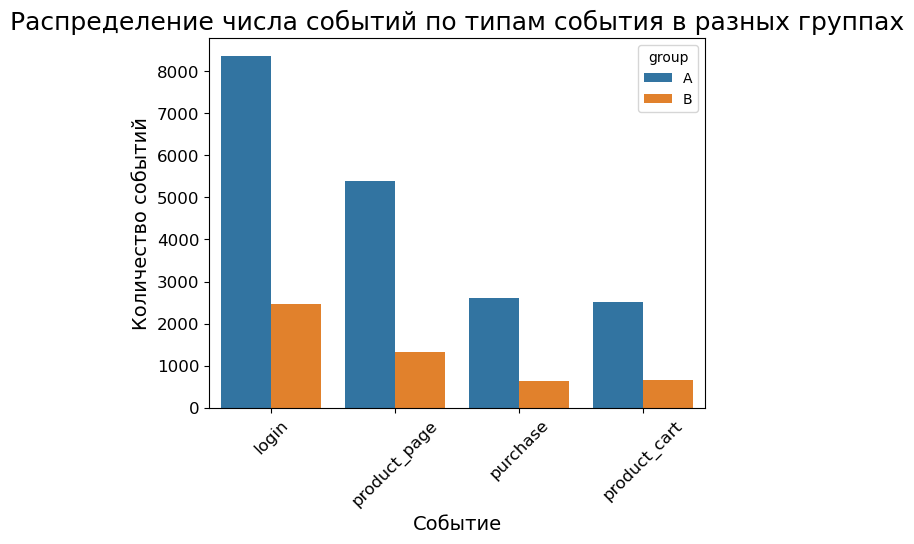

In [214]:
sns.barplot(data=funnel, x="event_name", y="event_cnt", hue="group")

plt_design(title='Распределение числа событий по типам события в разных группах',
               xlabel='Событие', 
               ylabel='Количество событий',
               xrot=45
               )

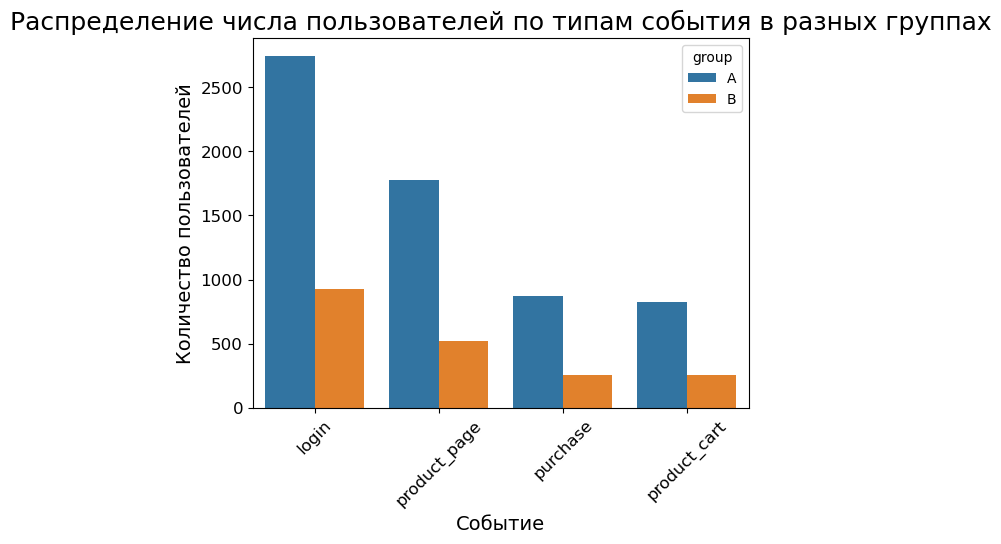

In [215]:
sns.barplot(data=funnel, x="event_name", y="user_cnt", hue="group")

plt_design(title='Распределение числа пользователей по типам события в разных группах',
               xlabel='Событие', 
               ylabel='Количество пользователей',
               xrot=45
               )

Самое большое по числу событие – событие login – главная страница. Также отметим, на обоих графиках события расположиены в одном порядке:

1) login – главная страница;
2) product page – открытие страницы товара;
3) purchase – покупка;
4) product cart – просмотр корзины.

Пользователи могут пропускать необязательные действия, например, просмотр корзины, поэтому количество этих событий меньше количества событий "покупка". Воронка должна заканчиваться на целевом действии, то есть на "покупке". Учитывая это выстроим воронку: "login" -> "product page" -> " product cart " -> "purchase".

In [216]:
funnel_a = funnel.query('group == "A"')
funnel_b = funnel.query('group == "B"')


funnel_a = funnel_a.iloc[[0,1,3,2],:]
funnel_b = funnel_b.iloc[[0,1,3,2],:]

display(funnel_a, funnel_b)

,event_name,group,event_cnt,user_cnt
0,login,A,8371,2747
4,product_page,A,5396,1780
2,product_cart,A,2508,824
6,purchase,A,2605,872


,event_name,group,event_cnt,user_cnt
1,login,B,2475,927
5,product_page,B,1323,523
3,product_cart,B,656,255
7,purchase,B,638,256


Получили две воронки, заканчивающиеся целевым действием – покупкой – для групп A и B.


#### Подсчет конверсии на разных этапах
Теперь с помощью воронки событий выясним, как меняется доля пользователей на каждом шаге относительно первого шага (возьмем его за 100%) в разных группах.

In [217]:

for df in [funnel_a, funnel_b]:
    df['conversion%'] = (df['user_cnt'] / df['user_cnt'].max()).round(3)*100 
    display(df)
    
fig = px.funnel(funnel_a, x='conversion%', y='event_name',  title='Воронка событий для группы A')
fig.show()
fig = px.funnel(funnel_b, x='conversion%', y='event_name',  title='Воронка событий для группы B')
fig.show();


,event_name,group,event_cnt,user_cnt,conversion%
0,login,A,8371,2747,100.0
4,product_page,A,5396,1780,64.8
2,product_cart,A,2508,824,30.0
6,purchase,A,2605,872,31.7


,event_name,group,event_cnt,user_cnt,conversion%
1,login,B,2475,927,100.0
5,product_page,B,1323,523,56.4
3,product_cart,B,656,255,27.5
7,purchase,B,638,256,27.6


**Воронка группы А:**

Уже на первом шаге – переход из главного меню к карточке товара – отваливается 35% пользователей. Это самая крупная потеря пользователей во всей воронке. Отметим также, что 32% всех пользователей доходят до целевого действия. 

**Воронка группы B:**
На первом шаге – переход из главного меню к карточке товара – потеря пользователей больше, чем в группе А (44% против 35%). Это так же самая крупная потеря пользователей во всей воронке. 28% всех пользователей оказываются на шаге "покупка".

**Промежуточный вывод**

На данном этапе проекта была построена воронка событий. События происходят в следующем порядке: 1)главная страница - 2) страница товара - 3) корзина - 4) оплата товара. Самое популярное событие – появление главной страницы – первый шаг полученной воронки. Самая большая доля пользователей отпадает при переходе с первого шага на второй – переход с главной страницы на страницу с товаром. В группе А: 32% всех пользователей доходят до целевого действия. В группе B конверсия целевого действия: 28%.

<a id='вывод_4'></a>
### 4.5 Вывод

На данном этапе мы исследовали группы А и В. Исследование показало:

- Число событий на пользователя в группах распределено одинаково. Количество событий на пользователя что в группе А, что в группе В, находится в диапазоне от 1 до 25. И основная масса значений в обеих группах сконцентрирована на отметке 6;
- Число событий пользователей группы А по показателям выше показателей группы B. Наблюдается сильный рост в даты 13-12-2020 – 21-12-2020. Здесь активность группы А сильно возрастает, достигает максимума 21 янаваря и резко идет на понижение. Число событий в группе В колеблется в диапазоне 200–300 событий, и 21-12-2020 так же, как и в группе А, идут на понижение.
- Анализ числа пользователей и событий по типу события показал, что пользователи могут пропускать необязательные действия, например, просмотр корзины, поэтому количество этих событий меньше количества событий "покупка". Воронка должна заканчиваться на целевом действии, то есть на "покупке". Учитывая мы построили воронку с такими шагами: "login" -> "product page" -> " product cart " -> "purchase". 

<a id='тест'></a>
## 5 Оценка результатов A/B-тестирования

<a id='результаты_теста'></a>
### 5.1 Результаты A/B-тестирования

- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

<a id='з-критерий'></a>
###  5.2 Проверка статистической разницы долей z-критерием

Сформулируем и проверим гипотезы.
- **$H_0$:** разницы в конверсиях пользователей, дошедших до события ('product_page', 'product_cart' или 'purchase'), между выборками A и B нет. 
- **$H_1$:** разница есть. Группы А и B демонстрируют разную конверсию.

In [218]:
def check(event):
    successesx = events_groups.query('group == "A" & event_name == @event')['user_id'].nunique()
    successesy = events_groups.query('group == "B" & event_name == @event')['user_id'].nunique()
    trialsx = events_groups.query('group == "A"')['user_id'].nunique()
    trialsy = events_groups.query('group == "B"')['user_id'].nunique()
                
    data = {'group':['A', 'B'],
            'successes': [successesx, successesy], 
            'trials': [trialsx, trialsy ],
            'share':[(successesx/trialsx),(successesy/trialsy)]
            } 
    table = pd.DataFrame(data)
    
    alpha = 0.1 / 3 # критический уровень статистической значимости
    
    successes = np.array([successesx, successesy])
    trials = np.array([trialsx, trialsy])
    
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    
    print(successes[0], successes[1],trials[0] , trials[1])
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2 
        
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'Для события "{event}":')
    display(table)
    print(f'p-value: {"{0:.3f}".format(p_value)}')
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 
        print()     
        print()
    

In [219]:
for event in ['product_page', 'product_cart', 'purchase']:
    check(event)

1780 523 2747 928
Для события "product_page":


,group,successes,trials,share
0,A,1780,2747,0.647980
1,B,523,928,0.563578


p-value: 0.000
Отвергаем нулевую гипотезу: между долями есть значимая разница
824 255 2747 928
Для события "product_cart":


,group,successes,trials,share
0,A,824,2747,0.299964
1,B,255,928,0.274784


p-value: 0.145
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


872 256 2747 928
Для события "purchase":


,group,successes,trials,share
0,A,872,2747,0.317437
1,B,256,928,0.275862


p-value: 0.018
Отвергаем нулевую гипотезу: между долями есть значимая разница


<a id='вывод_5'></a>
### 5.3 Вывод

На данном этапе были проверены три гипотезы:
1) Конверсия группы B на шаге "просмотр карточек товаров" не отличается от конверсии группы А;
2) Конверсия группы B на шаге "просмотры корзины " не отличается от конверсии группы А;
3) Конверсия группы B на шаге "покупки" не отличается от конверсии группы А.

Получены следующие рузультаты проверок:
- 2 гипотеза подтвердилась: Конверсия шага "просмотр корзины" группы В не отличается относительно группы А.
- 1 и 3 гипотезы не подтвердились: Разница между показателями конверсии в группах есть. 


<a id='вывод_6'></a>
## 6 Вывод

Данная работа была нацелена на проверку корректности А/В-теста. Для этого были проделаны следующие шаги и получены соответсвующие результаты:

- **Предобработка данных**
    
    Были приведены типы столбцов, содержащие значения даты-времени, к типу дата-время; пропущенные значения обнаружены только в датасете events в столбеце `details`. Их появление связано с назначением этого столбца (не каждому событию сопутствуют какие-то детали типа стоимости покупок) - этот столбец не использовался в данной работе; дубликатов в сете данных не оказалось;
---
- **Оценка корректности проведения теста**
    
    **Данный этап показал, что тест был проведен корректно.**
    
    На данном этапе оценивалась корректность проведения теста по следующим параметрам:
    - 1) Соответствие данных требованиям технического задания; 
    - 2) Время проведения теста;
    - 3) Аудитория теста;
    
    В каждом пункте сформулированы следующие выводы:
    
     **1) Соответствие данных требованиям технического задания:**
     - На этапе проверки дат мы убедились, что пользователей-участников нашего теста, зарегестрировавшихся позже 21-12-2020 - нет;
     - Проверка состава аудитории подтвердила, что 15% новых пользователей из региона EU;
     - На этапе проверки конверсий мы отсекли те события, которые пользователи не успели сделать в 14-дневный лайфтайм;
     - На этапе проверки количества участников теста мы выделили только тех пользователей, которые: а)зарегестрировались не позднее 21-12-2020; б) учатсвовали в тесте "recommender_system_test". Также проверка подтвердила, что участников теста 'recommender_system_test' больше 6000, а именно 6701. 

     **2) Время проведения теста:**
     - Найдены пересечения маркетинговых дат с датами проведения теста. Во время периода началась и закончилась кампания "Christmas&New Year Promo"; начались во время периода и закончились после: "CIS New Year Gift Lottery".
     - Число событий группы сильно изменяется, но не из-за проведения маркетинговых кампаний.

     **3) Аудитория теста:**
     - Пересечений между учатсниками разных групп не обнаружено;
     - Вес групп: А – 3824 участника, B – 2877. Разница между группами незначительна;
     - Обнаружены пересечения участников разных тестов.
        

---

- **Исследовательский анализ данных**
    - Число событий на пользователя в группах распределено одинаково. Количество событий на пользователя что в группе А, что в группе В, находится в диапазоне от 1 до 25. И основная масса значений в обеих группах сконцентрирована на отметке 6;
    - Число событий пользователей группы А по показателям выше показателей группы B. Наблюдается сильный рост в даты 13.12.2020 – 21.12.2020. Здесь активность группы А сильно возрастает, достигает максимума 21 янаваря и резко идет на понижение. Число событий в группе В колеблется в диапазоне 200–300 событий, и 21.12.2020 так же, как и в группе А, идут на понижение.
    - Анализ числа пользователей и событий по типу события показал, что пользователи могут пропускать необязательные действия, например, просмотр корзины, поэтому количество этих событий меньше количества событий "покупка". Воронка должна заканчиваться на целевом действии, то есть на "покупке". Учитывая это мы построили воронку с такими шагами: "login" -> "product page" -> " product cart " -> "purchase". 
---

- **Оценка результатов A/B-тестирования**

    На данном этапе были проверены три гипотезы:

    1) Конверсия группы B на шаге "просмотр карточек товаров" не отличается от конверсии группы А;
    2) Конверсия группы B на шаге "просмотры корзины " не отличается от конверсии группы А;
    3) Конверсия группы B на шаге "покупки" не отличается от конверсии группы А.
    
    Получены следующие рузультаты проверок:
    - 2 гипотеза подтвердилась: Конверсия шага "просмотр корзины" группы В не отличается относительно группы А.
    - 1 и 3 гипотезы не подтвердились: Разница между показателями конверсии в группах есть. 
    
     